In [7]:
ROOT = "./data/Market-1501/"
P = 5
K = 4

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T

from torch.utils.data import DataLoader

In [8]:
import src.data_tools.Market1501_New as MKT
import src.data_tools.UniformSampler as US
    

In [5]:
transform = T.Compose([
            T.ToTensor(),
            T.Resize(size=(256,128)),
            T.Pad(padding=10, fill=0),
            T.RandomCrop(size=(256,128)),
            T.RandomErasing()
    ])
    
test_transform = T.Compose([T.ToTensor(), T.Resize(size=(256,128))])



train_set = MKT.get_market1501_dataset(root=ROOT, mode="train", transform=transform)

In [11]:
train_set = MKT.get_market1501_dataset(root=ROOT, mode="train", transform=transform)
query_set = MKT.get_market1501_dataset(root=ROOT, mode="query", transform=test_transform)
test_set = MKT.get_market1501_dataset(root=ROOT, mode="test", transform=test_transform)

In [12]:
train_labels = train_set.labels
train_start_indices = {i : train_set.label_to_start_stop_idxs[label][0] 
                for i,label in enumerate(train_labels)}
train_num_examples = {i : 
                (train_set.label_to_start_stop_idxs[label][1] - \
                train_set.label_to_start_stop_idxs[label][0] + 1)
                for i, label in enumerate(train_labels)}
train_num_classes = len(train_labels)

train_k_at = US._get_k_at_time(start_indices=train_start_indices, num_examples=train_num_examples,
                                K=K, num_classes=train_num_classes)

train_sampler = US.ClassUniformBatchSampler(
        dataset=train_set, P=P, K=K, k_at_time=train_k_at, num_classes=train_num_classes,
        start_indices=train_start_indices, num_examples=train_num_examples
)

train_loader = DataLoader(dataset=train_set, batch_sampler=train_sampler, num_workers=0, pin_memory=True)

In [13]:
query_loader = DataLoader(query_set, batch_size=64, shuffle=False, drop_last=False, pin_memory=True)
gallery_loader = DataLoader(test_set, batch_size=64, shuffle=False, drop_last=False, pin_memory=True)

In [14]:
import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.axes_grid1 import ImageGrid


def display_batch(batch, P=P, K=K):
    """Displays the a batch as outputted by the dataloader,  as a PxK grid of images."""
    #logger.info(f"len(batch), batch[0].shape: {len(batch)}, {batch[0].shape}")
    fig = plt.figure(figsize=(20,20))
    grid = ImageGrid(fig, 111, nrows_ncols=(K, P), axes_pad=0.1)
    
    
    for ax, im_tensor in zip(grid, batch[0]):
        im_to_print = im_tensor.to("cpu").numpy()
        #put channel dimension at the end
        im_to_print = np.transpose(im_to_print, (1,2,0))
        ax.imshow(im_to_print)

    plt.show()        

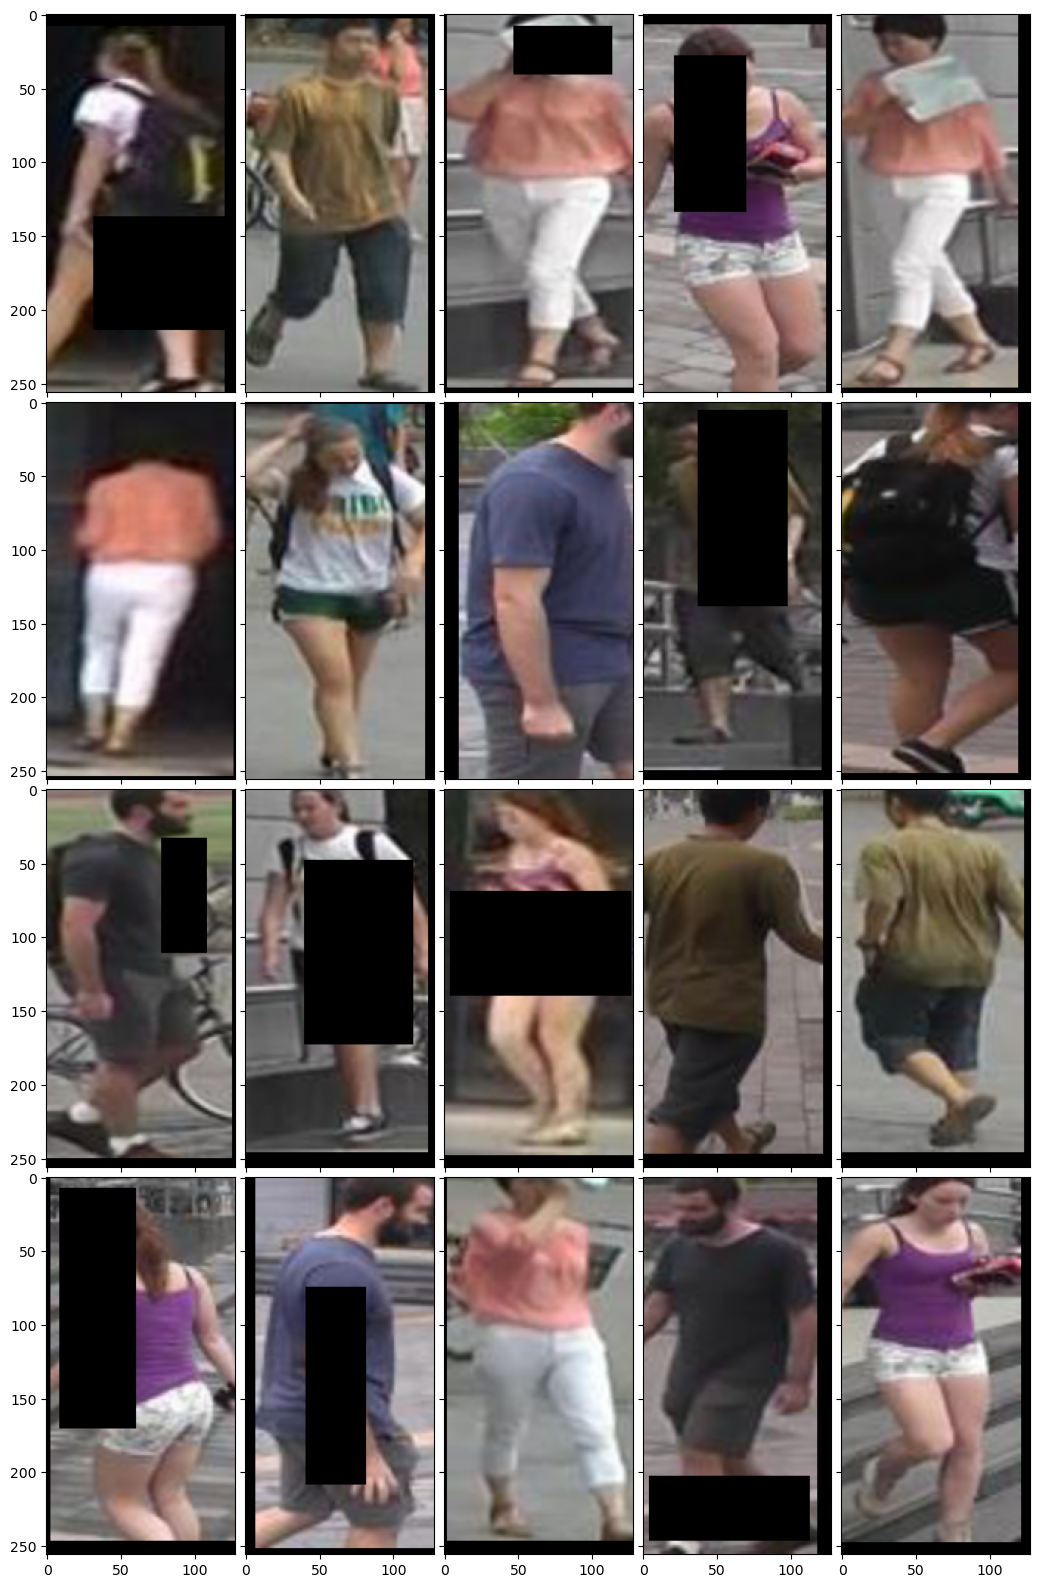

In [15]:
dataloader_iterator = iter(train_loader)

display_batch(next(dataloader_iterator))

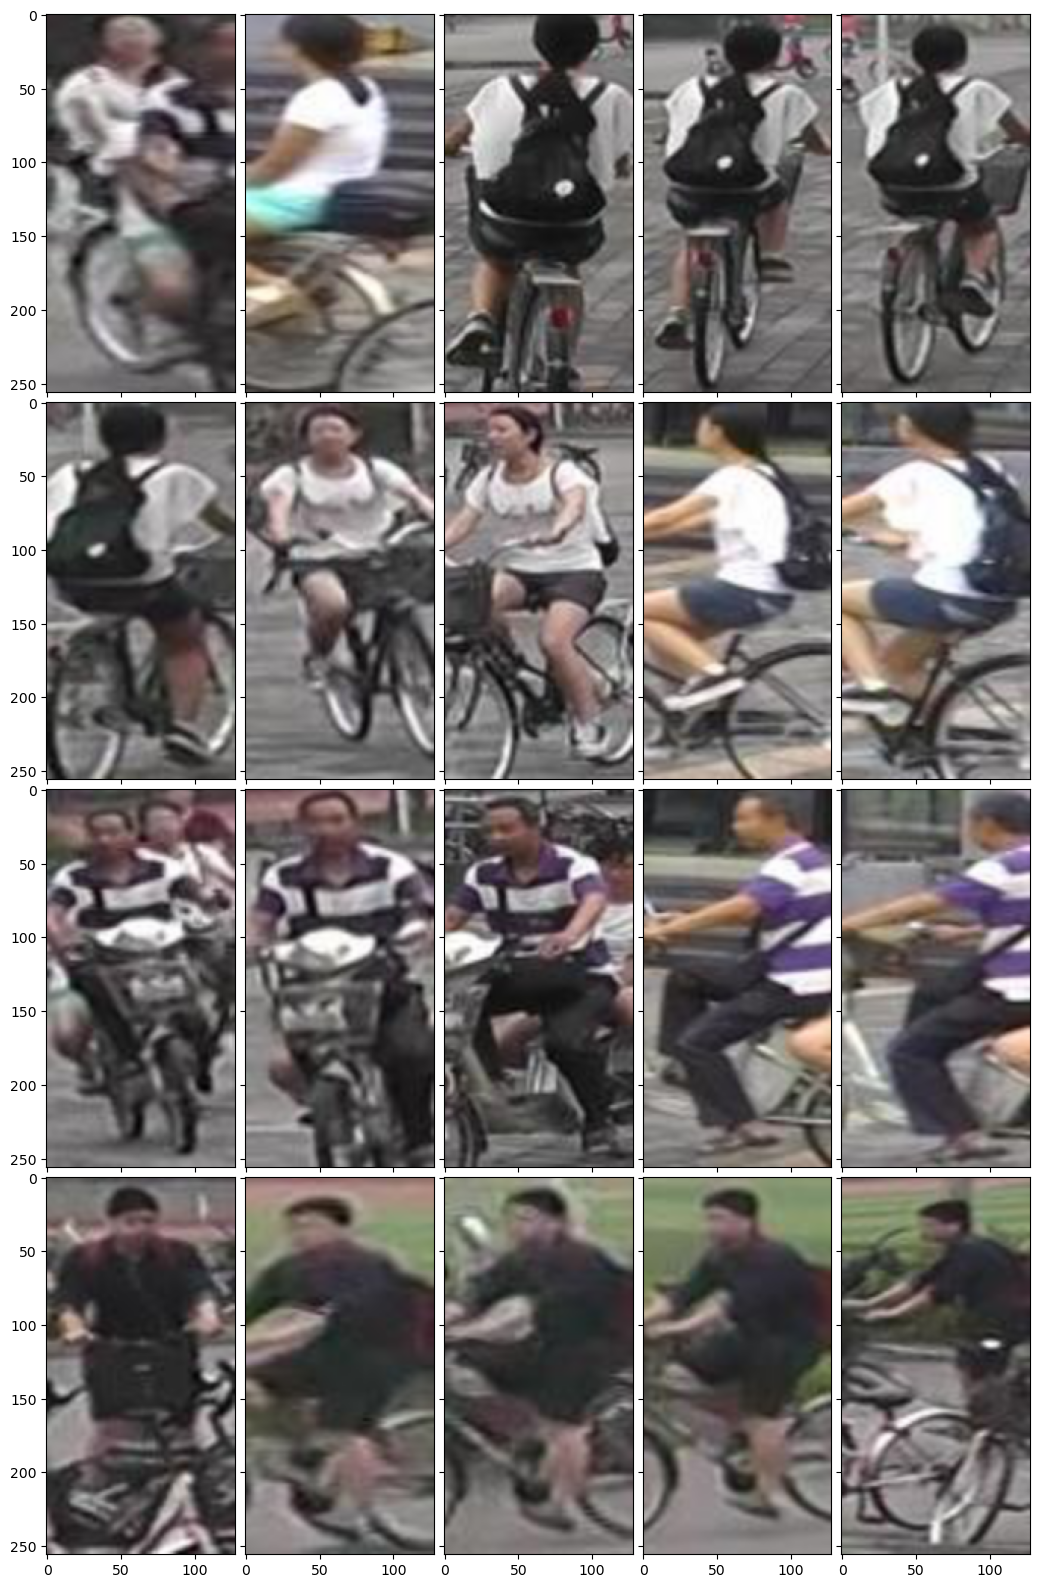

In [26]:
gallery_iter = iter(gallery_loader)
for i in range(46): #first images are to distract the model
    next(gallery_iter)
display_batch(next(gallery_iter))
#display_batch(next(gallery_iter))

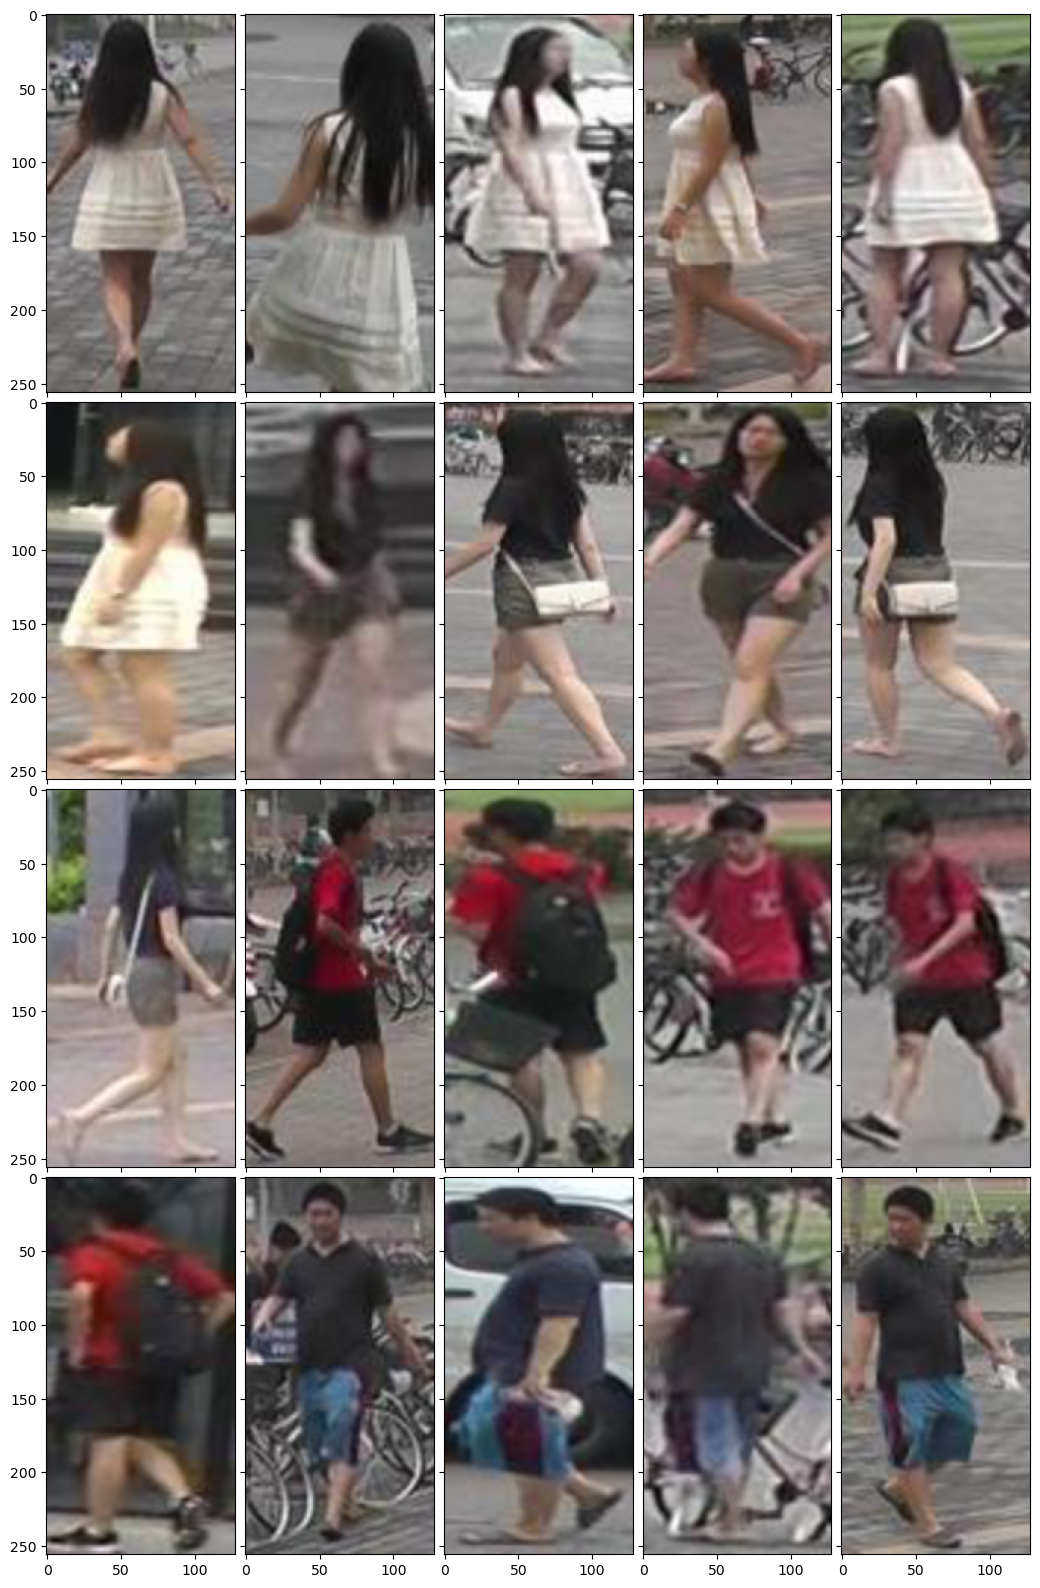

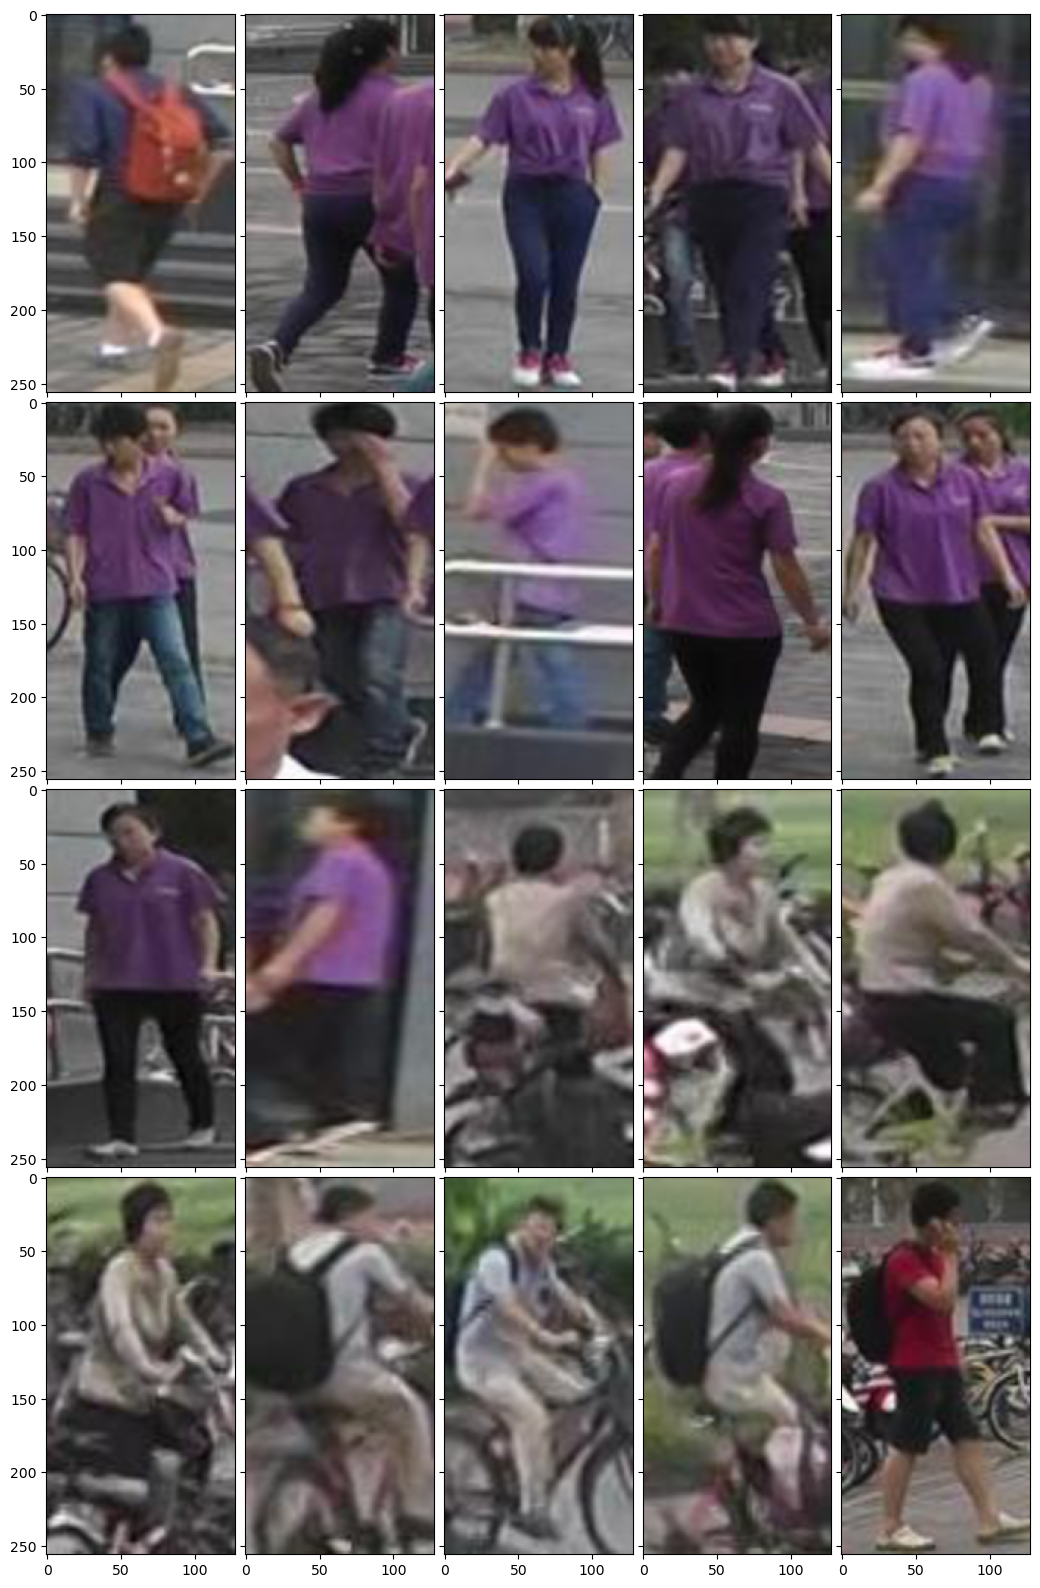

In [21]:
query_iter = iter(query_loader)
display_batch(next(query_iter))
display_batch(next(query_iter))